# Exoplanet Light Curve Analysis
This notebook retrieves multiple exoplanet data from NASA Exoplanet Archive, extracts advanced features from their light curves, and prepares datasets for training/testing ML models.

In [1]:
import os, math, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from lightkurve import search_lightcurvefile
from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

try:
    import xgboost as xgb
    HAS_XGBOOST = True
except Exception:
    HAS_XGBOOST = False

print('xgboost available:', HAS_XGBOOST)

xgboost available: True


In [3]:
def extract_features(flux):
    flux = np.array(flux)
    flux = flux[~np.isnan(flux)]
    if flux.size < 5:
        return None
    feats = {}
    feats['min'] = float(np.min(flux))
    feats['max'] = float(np.max(flux))
    feats['mean'] = float(np.mean(flux))
    feats['std'] = float(np.std(flux))
    feats['median'] = float(np.median(flux))
    feats['p10'] = float(np.percentile(flux,10))
    feats['p25'] = float(np.percentile(flux,25))
    feats['p75'] = float(np.percentile(flux,75))
    feats['p90'] = float(np.percentile(flux,90))
    feats['skew'] = float(skew(flux))
    feats['kurtosis'] = float(kurtosis(flux))
    feats['amplitude'] = feats['max'] - feats['min']
    feats['flux_ratio'] = feats['max']/feats['min'] if feats['min'] != 0 else 0.0
    feats['depth_proxy'] = float(feats['median'] - feats['min'])
    feats['duration_proxy'] = int(np.sum(flux < (feats['mean'] - feats['std'])))
    feats['autocorr_lag1'] = float(np.corrcoef(flux[:-1], flux[1:])[0,1]) if flux.size>1 else 0.0
    feats['var'] = float(np.var(flux))
    return feats

def safe_search_and_download(target_name, missions=['TESS','Kepler']):
    try:
        for mission in missions:
            try:
                s = search_lightcurvefile(target_name, mission=mission)
                if len(s) == 0:
                    continue
                lcfile = s.download()
                if hasattr(lcfile, 'PDCSAP_FLUX'):
                    lc = lcfile.PDCSAP_FLUX
                elif hasattr(lcfile, 'SAP_FLUX'):
                    lc = lcfile.SAP_FLUX
                else:
                    try:
                        lc = lcfile.get_lightcurve()
                    except Exception:
                        lc = None
                if lc is None:
                    continue
                lc = lc.remove_nans().normalize()
                return lc
            except Exception:
                continue
    except Exception:
        return None
    return None


In [4]:
print('Querying NASA Exoplanet Archive...')
query = NasaExoplanetArchive.query_criteria(table='ps', select='pl_name, hostname, pl_orbper', where='pl_orbper IS NOT NULL AND hostname IS NOT NULL')
df_planets = query.to_pandas()
print('Planets with period:', len(df_planets))

MAX_HOSTS = 8
df_hosts = df_planets.drop_duplicates(subset=['hostname']).head(MAX_HOSTS)
print('Selected hosts:', df_hosts['hostname'].tolist())


Querying NASA Exoplanet Archive...
Planets with period: 35714
Selected hosts: ['HD 70642', 'Kepler-20', 'Kepler-976', 'Kepler-188', 'K2-151', 'Kepler-61', 'Kepler-818', 'WASP-15']


In [5]:
features = []
labels = []
meta = []

SEGS_PER_HOST = 20
SEG_LENGTH = 200

for idx, row in df_hosts.iterrows():
    host = row['hostname']
    period = row['pl_orbper']
    planet = row['pl_name']
    print('Processing', host, '(', planet, ')')
    lc = safe_search_and_download(host)
    if lc is None:
        print('  -> failed to get LC for', host)
        continue
    try:
        if period is not None and not np.isnan(period) and period>0:
            lc_folded = lc.fold(period=float(period))
            flux = lc_folded.flux.value
        else:
            flux = lc.flux.value
    except Exception:
        flux = lc.flux.value
    if len(flux) < SEG_LENGTH:
        if len(flux) < 30:
            print('  -> too short, skip', host)
            continue
        reps = math.ceil(SEG_LENGTH / len(flux))
        flux = np.tile(flux, reps)[:SEG_LENGTH*SEGS_PER_HOST]
    seg_size = len(flux)//SEGS_PER_HOST
    for i in range(SEGS_PER_HOST):
        seg = flux[i*seg_size:(i+1)*seg_size]
        if len(seg) < 10:
            continue
        feats = extract_features(seg)
        if feats is None:
            continue
        features.append(feats)
        labels.append(1)
        meta.append({'host': host, 'planet': planet})

# negative noise samples
for i in range(150):
    noise = np.random.normal(1.0, 0.01, SEG_LENGTH)
    feats = extract_features(noise)
    features.append(feats)
    labels.append(0)
    meta.append({'host':'noise','planet':None})

df_feats = pd.DataFrame(features)
df_feats['label'] = labels
df_meta = pd.DataFrame(meta)
print('Dataset shape:', df_feats.shape)
df_feats.head()


Processing HD 70642 ( HD 70642 b )
Processing Kepler-20 ( Kepler-20 d )
Processing Kepler-976 ( Kepler-976 b )
Processing Kepler-188 ( Kepler-188 c )
Processing K2-151 ( K2-151 b )
Processing Kepler-61 ( Kepler-61 b )
Processing Kepler-818 ( Kepler-818 b )
Processing WASP-15 ( WASP-15 b )
Dataset shape: (310, 18)


,min,max,mean,std,median,p10,p25,p75,p90,skew,kurtosis,amplitude,flux_ratio,depth_proxy,duration_proxy,autocorr_lag1,var,label
0,0.999499,1.000941,1.000038,0.000211,1.000027,0.999791,0.999888,1.000172,1.000304,0.477653,0.676959,0.001441,1.001442,0.000528,102,0.010160,4.465333e-08,1
1,0.999451,1.001064,1.000020,0.000205,1.000003,0.999772,0.999883,1.000157,1.000270,0.467215,1.317778,0.001613,1.001614,0.000552,92,0.055471,4.196041e-08,1
2,0.999414,1.000972,1.000002,0.000209,1.000004,0.999747,0.999862,1.000130,1.000257,0.326734,1.141171,0.001558,1.001559,0.000591,103,-0.035115,4.350530e-08,1
3,0.999414,1.000741,0.999999,0.000200,1.000000,0.999759,0.999856,1.000127,1.000251,0.200425,0.434708,0.001327,1.001328,0.000586,103,0.003757,4.002953e-08,1
4,0.999497,1.000654,0.999993,0.000209,0.999989,0.999741,0.999844,1.000132,1.000243,0.266539,-0.000410,0.001156,1.001157,0.000492,118,0.059055,4.353536e-08,1


In [6]:
# Prepare X,y
X = df_feats.drop(columns=['label'])
y = df_feats['label'].astype(int)
print('Class counts:', y.value_counts().to_dict())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

models = {}
models['logreg'] = LogisticRegression(max_iter=1000)
models['rf'] = RandomForestClassifier(n_estimators=200, random_state=42)
if HAS_XGBOOST:
    models['xgb'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

results = {}
for name, mdl in models.items():
    print('\nTraining', name)
    Xtr = X_train_s if name in ['logreg','xgb'] else X_train
    Xte = X_test_s if name in ['logreg','xgb'] else X_test
    mdl.fit(Xtr, y_train)
    preds = mdl.predict(Xte)
    proba = mdl.predict_proba(Xte)[:,1] if hasattr(mdl,'predict_proba') else None
    print(classification_report(y_test, preds))
    if proba is not None:
        print('ROC AUC:', roc_auc_score(y_test, proba))
    if hasattr(mdl, 'feature_importances_'):
        fi = pd.Series(mdl.feature_importances_, index=X.columns).sort_values(ascending=False)
        print('Top features:\n', fi.head(8))
    results[name] = mdl


Class counts: {1: 160, 0: 150}

Training logreg
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        40

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

ROC AUC: 1.0

Training rf
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        40

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

ROC AUC: 1.0
Top features:
 duration_proxy    0.407159
max               0.095545
amplitude         0.089219
flux_ratio        0.080600
std               0.063494
var               0.047017
min               0.046592
depth_proxy       0.041716
dtype: float64

Training xgb

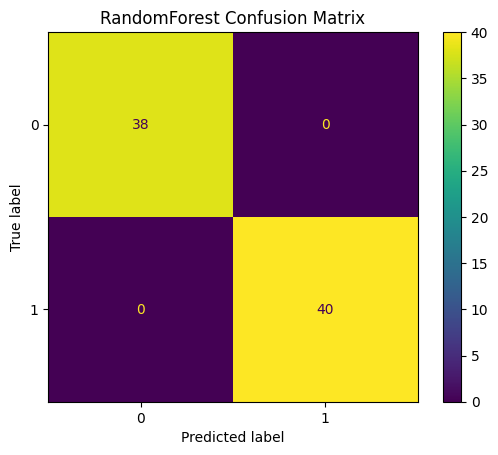

<Figure size 1000x400 with 0 Axes>

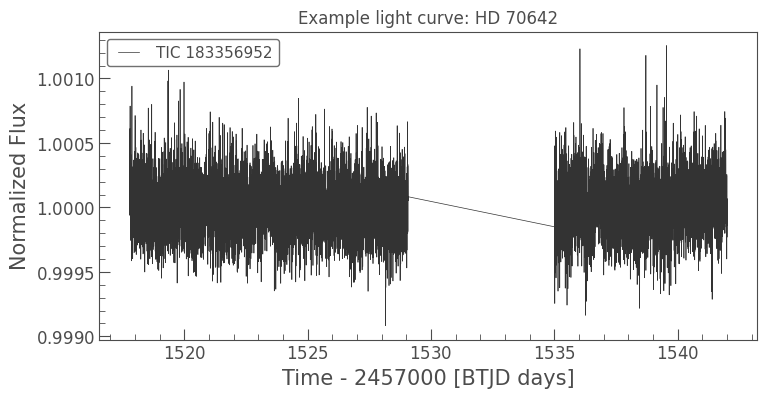

Saved artifacts to ./artifacts


In [7]:
# Confusion matrix for RF
from sklearn.metrics import ConfusionMatrixDisplay
if 'rf' in results:
    ConfusionMatrixDisplay.from_estimator(results['rf'], X_test, y_test)
    plt.title('RandomForest Confusion Matrix')
    plt.show()

# example LC plot
try:
    example_host = df_hosts['hostname'].iloc[0]
    lc_ex = safe_search_and_download(example_host)
    if lc_ex is not None:
        plt.figure(figsize=(10,4))
        lc_ex.plot()
        plt.title(f'Example light curve: {example_host}')
        plt.show()
except Exception as e:
    print('Plot LC failed:', e)

# Save artifacts
os.makedirs('artifacts', exist_ok=True)
df_feats.to_csv('artifacts/features_dataset.csv', index=False)
import joblib
joblib.dump(scaler, 'artifacts/scaler.joblib')
for name, mdl in results.items():
    joblib.dump(mdl, f'artifacts/model_{name}.joblib')
print('Saved artifacts to ./artifacts')
